In [1]:
from class_dataset import ChestDataset
import pandas as pd
from keras.callbacks import TensorBoard, ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.applications import DenseNet121
from keras import models
from keras import backend as K
from keras.metrics import top_k_categorical_accuracy
from tensorflow.python.client import device_lib
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import os
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder,MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score, precision_score,precision_recall_curve
from sklearn.metrics import recall_score,classification_report,roc_curve,auc
from itertools import chain
from collections import Counter
from glob import glob
import tensorflow as tf
from random import shuffle
import keras
import cv2
from scipy import ndimage

/opt/ds3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())
os.system('sudo chown -R ds:ds /data')
if not os.path.exists('./output/'):
    os.mkdir('output')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12306216802192954258
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11287530701
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9657688983981457282
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


In [12]:
# CHOOSE now your model name 
model_name = 'densechest_multilabel_aug'

csvfile = 'data_kaggle/Data_Entry_2017.csv'
df = pd.read_csv(csvfile)

data_dir = '/data/xray_chest_final/'

ChestDataset(data_dir,df).reset_folder()

df = ChestDataset(data_dir,df).reader
df = df[df.exists == True]

In [13]:
def balance_df(val,frac):
    row_to_drop = [idx for i,idx in enumerate(df[df['Finding Labels'] == val].index.values) if i%frac==0]
    return df.drop(row_to_drop)

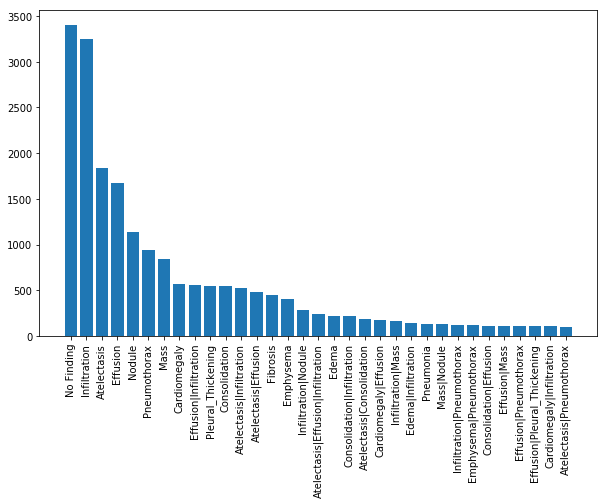

Total Images:  19934


In [14]:
count = df['Finding Labels'].value_counts() 
labels_to_keep = count[count > 100].index.values
df = df[df['Finding Labels'].isin(labels_to_keep)]
df['labels'] = df['Finding Labels'].apply(lambda x:'' if x=='No Finding' else x.split('|'))
binarizer = MultiLabelBinarizer()
binarizer.fit(df.labels)
df['target'] = list(binarizer.transform(df.labels))
df = balance_df('No Finding',2)
df = balance_df('No Finding',2)
df = balance_df('No Finding',2)
count = df['Finding Labels'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(count.index.values,count)
plt.xticks(rotation=90)
plt.show()

print('Total Images: ',len(df))

In [15]:
dataset = ChestDataset(data_dir,df)
train_list = [el[len(data_dir):] for i,el in enumerate(dataset.image_path) if not i%5 == 0]
test_list = [el[len(data_dir):] for i,el in enumerate(dataset.image_path) if i%5 == 0]

In [16]:
with open('output/{}_train_list.txt'.format(model_name), 'w') as f:
    for item in train_list:
        f.write("%s\n" % item)

with open('output/{}_test_list.txt'.format(model_name), 'w') as f:
    for item in test_list:
        f.write("%s\n" % item)

train_dt,test_dt = dataset.train_test(train_list,test_list)
# train_dt.create_tree()
# test_dt.create_tree()

train_files = train_dt.image_path
test_files = test_dt.image_path
# train_folder = train_dt.dir
# test_folder = test_dt.dir

/home/ds/notebooks/class_dataset.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.reader['exists'] = self.exists


In [17]:
# ADD YOUR MODEL
img_width,img_height = 256,256
densenet = DenseNet121(weights='imagenet', include_top=False,input_shape = (img_width, img_height, 3))

# # Freeze some layers
# for layer in densenet.layers[:100]:
#     layer.trainable = False
    
# Create the model
model = models.Sequential()

model.add(densenet)

# Add new layers
model.add(Flatten())
# model.add(Dense(72))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

30015488/30011760 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
activation_1 (Activation)    (None, 65536)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                851981    
Total params: 7,889,485
Trainable params: 7,805,837
Non-trainable params: 83,648
_________________________________________________________________


In [18]:
def rotate(img,deg):
    return ndimage.rotate(img,deg)

def stdize(img):
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    for i in range(img.shape[2]):
        img[:,:,i] = (img[:,:,i] - means[i])/stds[i]
    return img

def get_input(path):
    img = cv2.imread(path)
    img = cv2.resize(img,(256,256))
    img = img/255.0
#     img = stdize(img)
    return img

def get_label(path):
    index = path.split('/')[-1]
    label = df.labels[df['Image Index'] == index].values[0]
    return label

def preprocess(img):
    batch = [img]
    prob = 0.2
    if np.random.normal() > prob:
        img_aug = rotate(img,90)
        batch += [img_aug]
    if np.random.normal() > prob:
        img_aug = rotate(img,180)
        batch += [img_aug]
    if np.random.normal() > prob:
        img_aug = rotate(img,-90)    
        batch += [img_aug]
    if np.random.normal() > prob:
        img_aug = np.flipud(img)    
        batch += [img_aug]
    if np.random.normal() > prob:
        img_aug = np.fliplr(img)    
        batch += [img_aug]
    return batch


def ChestGen(files, batch_size = 16,augment = False):
    shuffle(files)
    idx = 0
    while True:
        # Select files (paths/indices) for the batch
        if idx + batch_size > len(files):
            batch_paths = files[idx:]
        else:
            batch_paths = files[idx:idx + batch_size]
        batch_input = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for input_path in batch_paths:
            x = get_input(input_path)
            y = get_label(input_path)
            vec = binarizer.transform([(y)])
            batch_input += [x]
            batch_output += list(vec)

            if y != '' and augment:
                batch_prep = preprocess(x)
                batch_input += batch_prep
                batch_output += list(vec)*len(batch_prep)
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        idx += batch_size

        yield(batch_x, batch_y)
        
        if idx > len(files):
            idx = 0

In [19]:
# serialize model to JSON
model_json = model.to_json()
with open("output/{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
    

train_batchsize = 5
val_batchsize = 5

train_path = glob(data_dir +'train/*')
test_path = glob(data_dir + 'test/*')

train_generator = ChestGen(train_path,train_batchsize,augment=True)
test_generator = ChestGen(test_path,val_batchsize,augment=False)

In [20]:
#statistics
print('No finding in Train: ', train_dt.labels.count('No Finding')/len(train_dt.labels))
print('No finding in Test: ', test_dt.labels.count('No Finding')/len(test_dt.labels))
print('Total number of image: ', len(dataset.image_path))

No finding in Train:  0.1669906565498213
No finding in Test:  0.18409831953850012
Total number of image:  19934


In [26]:
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    pr = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((pr*rec)/(pr+rec+K.epsilon()))


In [21]:
# Compile the model
optimizer = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=[top_k_categorical_accuracy,'categorical_accuracy'])

tensorboard = TensorBoard(log_dir='output/logs', histogram_freq=0,
                          write_graph=True, write_images=False)
filepath = "output/checkpoint_{}.hdf5".format(model_name)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
lr_sc = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,verbose=1)


# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_path) // train_batchsize,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(test_path) // val_batchsize,
    verbose=1,
    callbacks=[tensorboard,checkpoint,lr_sc],
    use_multiprocessing=True)

Epoch 1/1
3189/3189 [==============================] - 2540s 796ms/step - loss: 0.5108 - top_k_categorical_accuracy: 0.7351 - categorical_accuracy: 0.2170 - val_loss: 0.6594 - val_top_k_categorical_accuracy: 0.8560 - val_categorical_accuracy: 0.2344

Epoch 00001: val_loss improved from inf to 0.65936, saving model to output/checkpoint_densechest_multilabel_aug.hdf5


In [22]:
# serialize weights to HDF5
model.save_weights("output/{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [27]:
model.load_weights(filepath)
optimizer = Adam(lr=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=[top_k_categorical_accuracy,'categorical_accuracy',f1])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_path) // train_batchsize,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(test_path) // val_batchsize,
    verbose=1,
    callbacks=[tensorboard,checkpoint,lr_sc],
    use_multiprocessing=True)

Epoch 1/5
3189/3189 [==============================] - 2454s 769ms/step - loss: 0.3625 - top_k_categorical_accuracy: 0.7585 - categorical_accuracy: 0.2245 - f1: 0.0125 - val_loss: 0.7029 - val_top_k_categorical_accuracy: 0.7932 - val_categorical_accuracy: 0.1719 - val_f1: 0.0160

Epoch 00001: val_loss did not improve from 0.65936
Epoch 2/5
3189/3189 [==============================] - 2417s 758ms/step - loss: 0.3521 - top_k_categorical_accuracy: 0.7693 - categorical_accuracy: 0.2301 - f1: 0.0163 - val_loss: 0.3087 - val_top_k_categorical_accuracy: 0.8118 - val_categorical_accuracy: 0.2078 - val_f1: 0.0173

Epoch 00002: val_loss improved from 0.65936 to 0.30870, saving model to output/checkpoint_densechest_multilabel_aug.hdf5
Epoch 3/5
3189/3189 [==============================] - 2414s 757ms/step - loss: 0.3601 - top_k_categorical_accuracy: 0.7747 - categorical_accuracy: 0.2409 - f1: 0.0202 - val_loss: 0.4961 - val_top_k_categorical_accuracy: 0.8580 - val_categorical_accuracy: 0.2650 - v

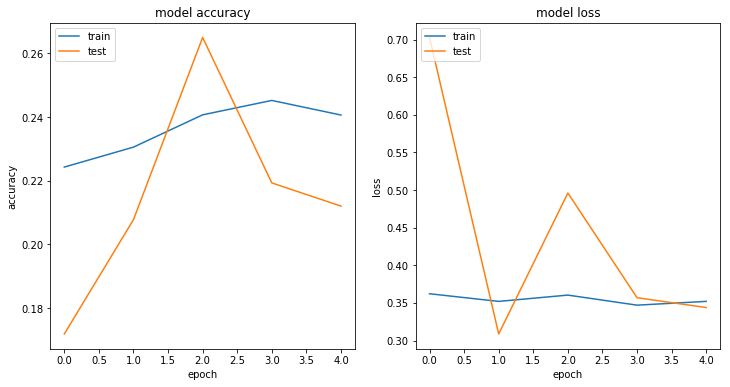

In [30]:
#metrics
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('output/history_{}.png'.format(model_name))

In [31]:
test_generator = ChestGen(test_path,val_batchsize,augment=False)
prediction = model.predict_generator(test_generator,
                                     steps=len(test_path)//val_batchsize,
                                     verbose=1,
                                    use_multiprocessing=True)

797/797 [==============================] - 91s 114ms/step


In [32]:
preds = np.round(prediction)
test_generator = ChestGen(test_path,1,augment=False)
y_true = np.zeros_like(prediction)
for i,el in enumerate(test_generator):
    print('Processed: {}\r'.format(i))
    y_true[i,:] = el[1]

Processed: 0
Processed: 1
Processed: 2
Processed: 3
Processed: 4
Processed: 5
Processed: 6
Processed: 7
Processed: 8
Processed: 9
Processed: 10
Processed: 11
Processed: 12
Processed: 13
Processed: 14
Processed: 15
Processed: 16
Processed: 17
Processed: 18
Processed: 19
Processed: 20
Processed: 21
Processed: 22
Processed: 23
Processed: 24
Processed: 25
Processed: 26
Processed: 27
Processed: 28
Processed: 29
Processed: 30
Processed: 31
Processed: 32
Processed: 33
Processed: 34
Processed: 35
Processed: 36
Processed: 37
Processed: 38
Processed: 39
Processed: 40
Processed: 41
Processed: 42
Processed: 43
Processed: 44
Processed: 45
Processed: 46
Processed: 47
Processed: 48
Processed: 49
Processed: 50
Processed: 51
Processed: 52
Processed: 53
Processed: 54
Processed: 55
Processed: 56
Processed: 57
Processed: 58
Processed: 59
Processed: 60
Processed: 61
Processed: 62
Processed: 63
Processed: 64
Processed: 65
Processed: 66
Processed: 67
Processed: 68
Processed: 69
Processed: 70
Processed: 71
Pr

Processed: 555
Processed: 556
Processed: 557
Processed: 558
Processed: 559
Processed: 560
Processed: 561
Processed: 562
Processed: 563
Processed: 564
Processed: 565
Processed: 566
Processed: 567
Processed: 568
Processed: 569
Processed: 570
Processed: 571
Processed: 572
Processed: 573
Processed: 574
Processed: 575
Processed: 576
Processed: 577
Processed: 578
Processed: 579
Processed: 580
Processed: 581
Processed: 582
Processed: 583
Processed: 584
Processed: 585
Processed: 586
Processed: 587
Processed: 588
Processed: 589
Processed: 590
Processed: 591
Processed: 592
Processed: 593
Processed: 594
Processed: 595
Processed: 596
Processed: 597
Processed: 598
Processed: 599
Processed: 600
Processed: 601
Processed: 602
Processed: 603
Processed: 604
Processed: 605
Processed: 606
Processed: 607
Processed: 608
Processed: 609
Processed: 610
Processed: 611
Processed: 612
Processed: 613
Processed: 614
Processed: 615
Processed: 616
Processed: 617
Processed: 618
Processed: 619
Processed: 620
Processed:

Processed: 1099
Processed: 1100
Processed: 1101
Processed: 1102
Processed: 1103
Processed: 1104
Processed: 1105
Processed: 1106
Processed: 1107
Processed: 1108
Processed: 1109
Processed: 1110
Processed: 1111
Processed: 1112
Processed: 1113
Processed: 1114
Processed: 1115
Processed: 1116
Processed: 1117
Processed: 1118
Processed: 1119
Processed: 1120
Processed: 1121
Processed: 1122
Processed: 1123
Processed: 1124
Processed: 1125
Processed: 1126
Processed: 1127
Processed: 1128
Processed: 1129
Processed: 1130
Processed: 1131
Processed: 1132
Processed: 1133
Processed: 1134
Processed: 1135
Processed: 1136
Processed: 1137
Processed: 1138
Processed: 1139
Processed: 1140
Processed: 1141
Processed: 1142
Processed: 1143
Processed: 1144
Processed: 1145
Processed: 1146
Processed: 1147
Processed: 1148
Processed: 1149
Processed: 1150
Processed: 1151
Processed: 1152
Processed: 1153
Processed: 1154
Processed: 1155
Processed: 1156
Processed: 1157
Processed: 1158
Processed: 1159
Processed: 1160
Processe

Processed: 1620
Processed: 1621
Processed: 1622
Processed: 1623
Processed: 1624
Processed: 1625
Processed: 1626
Processed: 1627
Processed: 1628
Processed: 1629
Processed: 1630
Processed: 1631
Processed: 1632
Processed: 1633
Processed: 1634
Processed: 1635
Processed: 1636
Processed: 1637
Processed: 1638
Processed: 1639
Processed: 1640
Processed: 1641
Processed: 1642
Processed: 1643
Processed: 1644
Processed: 1645
Processed: 1646
Processed: 1647
Processed: 1648
Processed: 1649
Processed: 1650
Processed: 1651
Processed: 1652
Processed: 1653
Processed: 1654
Processed: 1655
Processed: 1656
Processed: 1657
Processed: 1658
Processed: 1659
Processed: 1660
Processed: 1661
Processed: 1662
Processed: 1663
Processed: 1664
Processed: 1665
Processed: 1666
Processed: 1667
Processed: 1668
Processed: 1669
Processed: 1670
Processed: 1671
Processed: 1672
Processed: 1673
Processed: 1674
Processed: 1675
Processed: 1676
Processed: 1677
Processed: 1678
Processed: 1679
Processed: 1680
Processed: 1681
Processe

Processed: 2144
Processed: 2145
Processed: 2146
Processed: 2147
Processed: 2148
Processed: 2149
Processed: 2150
Processed: 2151
Processed: 2152
Processed: 2153
Processed: 2154
Processed: 2155
Processed: 2156
Processed: 2157
Processed: 2158
Processed: 2159
Processed: 2160
Processed: 2161
Processed: 2162
Processed: 2163
Processed: 2164
Processed: 2165
Processed: 2166
Processed: 2167
Processed: 2168
Processed: 2169
Processed: 2170
Processed: 2171
Processed: 2172
Processed: 2173
Processed: 2174
Processed: 2175
Processed: 2176
Processed: 2177
Processed: 2178
Processed: 2179
Processed: 2180
Processed: 2181
Processed: 2182
Processed: 2183
Processed: 2184
Processed: 2185
Processed: 2186
Processed: 2187
Processed: 2188
Processed: 2189
Processed: 2190
Processed: 2191
Processed: 2192
Processed: 2193
Processed: 2194
Processed: 2195
Processed: 2196
Processed: 2197
Processed: 2198
Processed: 2199
Processed: 2200
Processed: 2201
Processed: 2202
Processed: 2203
Processed: 2204
Processed: 2205
Processe

Processed: 2657
Processed: 2658
Processed: 2659
Processed: 2660
Processed: 2661
Processed: 2662
Processed: 2663
Processed: 2664
Processed: 2665
Processed: 2666
Processed: 2667
Processed: 2668
Processed: 2669
Processed: 2670
Processed: 2671
Processed: 2672
Processed: 2673
Processed: 2674
Processed: 2675
Processed: 2676
Processed: 2677
Processed: 2678
Processed: 2679
Processed: 2680
Processed: 2681
Processed: 2682
Processed: 2683
Processed: 2684
Processed: 2685
Processed: 2686
Processed: 2687
Processed: 2688
Processed: 2689
Processed: 2690
Processed: 2691
Processed: 2692
Processed: 2693
Processed: 2694
Processed: 2695
Processed: 2696
Processed: 2697
Processed: 2698
Processed: 2699
Processed: 2700
Processed: 2701
Processed: 2702
Processed: 2703
Processed: 2704
Processed: 2705
Processed: 2706
Processed: 2707
Processed: 2708
Processed: 2709
Processed: 2710
Processed: 2711
Processed: 2712
Processed: 2713
Processed: 2714
Processed: 2715
Processed: 2716
Processed: 2717
Processed: 2718
Processe

Processed: 3177
Processed: 3178
Processed: 3179
Processed: 3180
Processed: 3181
Processed: 3182
Processed: 3183
Processed: 3184
Processed: 3185
Processed: 3186
Processed: 3187
Processed: 3188
Processed: 3189
Processed: 3190
Processed: 3191
Processed: 3192
Processed: 3193
Processed: 3194
Processed: 3195
Processed: 3196
Processed: 3197
Processed: 3198
Processed: 3199
Processed: 3200
Processed: 3201
Processed: 3202
Processed: 3203
Processed: 3204
Processed: 3205
Processed: 3206
Processed: 3207
Processed: 3208
Processed: 3209
Processed: 3210
Processed: 3211
Processed: 3212
Processed: 3213
Processed: 3214
Processed: 3215
Processed: 3216
Processed: 3217
Processed: 3218
Processed: 3219
Processed: 3220
Processed: 3221
Processed: 3222
Processed: 3223
Processed: 3224
Processed: 3225
Processed: 3226
Processed: 3227
Processed: 3228
Processed: 3229
Processed: 3230
Processed: 3231
Processed: 3232
Processed: 3233
Processed: 3234
Processed: 3235
Processed: 3236
Processed: 3237
Processed: 3238
Processe

Processed: 3699
Processed: 3700
Processed: 3701
Processed: 3702
Processed: 3703
Processed: 3704
Processed: 3705
Processed: 3706
Processed: 3707
Processed: 3708
Processed: 3709
Processed: 3710
Processed: 3711
Processed: 3712
Processed: 3713
Processed: 3714
Processed: 3715
Processed: 3716
Processed: 3717
Processed: 3718
Processed: 3719
Processed: 3720
Processed: 3721
Processed: 3722
Processed: 3723
Processed: 3724
Processed: 3725
Processed: 3726
Processed: 3727
Processed: 3728
Processed: 3729
Processed: 3730
Processed: 3731
Processed: 3732
Processed: 3733
Processed: 3734
Processed: 3735
Processed: 3736
Processed: 3737
Processed: 3738
Processed: 3739
Processed: 3740
Processed: 3741
Processed: 3742
Processed: 3743
Processed: 3744
Processed: 3745
Processed: 3746
Processed: 3747
Processed: 3748
Processed: 3749
Processed: 3750
Processed: 3751
Processed: 3752
Processed: 3753
Processed: 3754
Processed: 3755
Processed: 3756
Processed: 3757
Processed: 3758
Processed: 3759
Processed: 3760
Processe

IndexError: index 3985 is out of bounds for axis 0 with size 3985

In [34]:
report = classification_report(y_true,preds)
np.save('output/report_{}.npy'.format(model_name),report)
print(report)
# print('Accuracy score: ',accuracy_score(y_true,preds))

             precision    recall  f1-score   support

          0       1.00      0.00      0.00       686
          1       0.00      0.00      0.00       152
          2       0.00      0.00      0.00       202
          3       0.00      0.00      0.00        69
          4       0.25      0.00      0.00       679
          5       0.00      0.00      0.00       103
          6       0.00      0.00      0.00        85
          7       0.21      0.01      0.02      1100
          8       0.00      0.00      0.00       243
          9       0.00      0.00      0.00       296
         10       0.00      0.00      0.00       140
         11       0.00      0.00      0.00        22
         12       0.00      0.00      0.00       287

avg / total       0.27      0.00      0.01      4064



/opt/ds3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
score = model.evaluate_generator(test_generator,
                                 steps=len(test_path)//val_batchsize,
                                 pickle_safe=True)
print('Accuracy Keras: ', score[1])

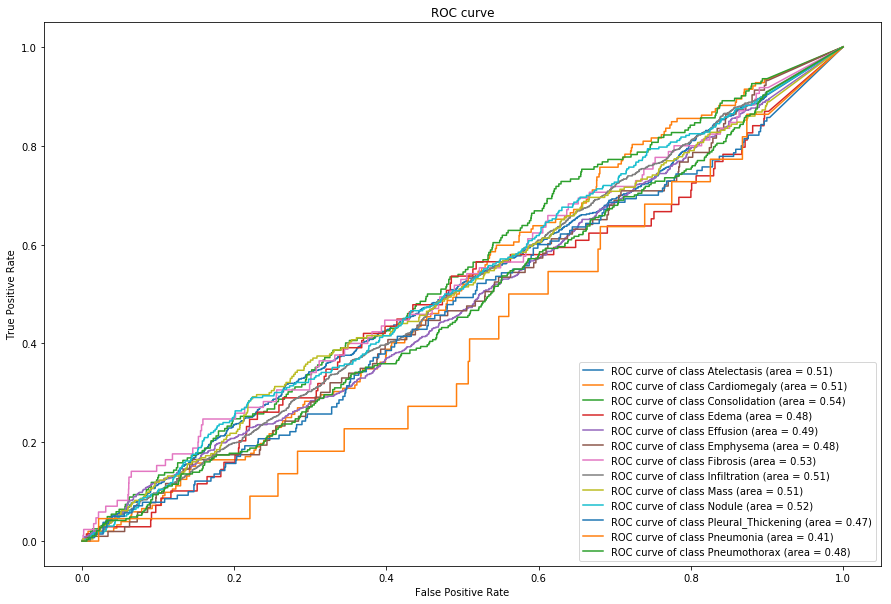

In [35]:
# Auc scores
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(binarizer.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig = plt.figure(figsize=(15,10))
for i in range(13):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(binarizer.classes_[i], roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
fig.savefig('output/roc_curve_{}.png'.format(model_name))

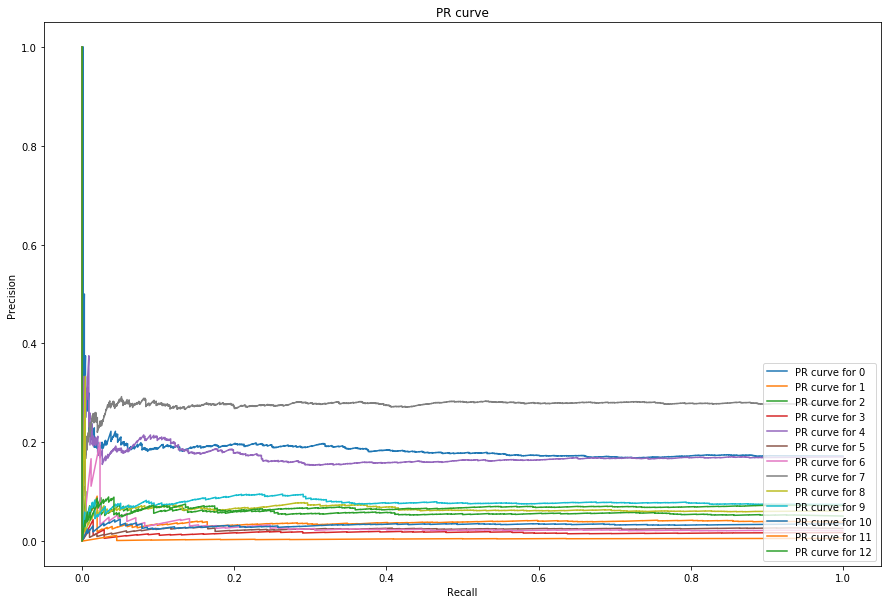

End Of Training


In [36]:
precision = dict()
recall = dict()
for i in range(len(binarizer.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], prediction[:, i])

fig = plt.figure(figsize=(15,10))
for i in range(13):
    plt.plot(recall[i], precision[i],
             label='PR curve for {0}'
             ''.format(i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc="lower right")
plt.show()

print('End Of Training')